In [3]:
import zipfile
z=zipfile.ZipFile("archive.zip")
z.extractall()

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

%matplotlib inline


In [3]:
DATASET_DIR = "chest_xray"
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10


In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)


In [1]:
import numpy as np
import tensorflow as tf

print(f"NumPy version: {np.__version__}")
print(f"TensorFlow version: {tf.__version__}")

# This line checks if the 'umath' error is truly gone
print("Success: TensorFlow and NumPy are talking!")

NumPy version: 1.26.4
TensorFlow version: 2.20.0
Success: TensorFlow and NumPy are talking!


In [5]:
train_generator = train_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, "train"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, "val"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, "test"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
class_labels = train_generator.class_indices
class_names = {v: k for k, v in class_labels.items()}
class_names


{0: 'NORMAL', 1: 'PNEUMONIA'}

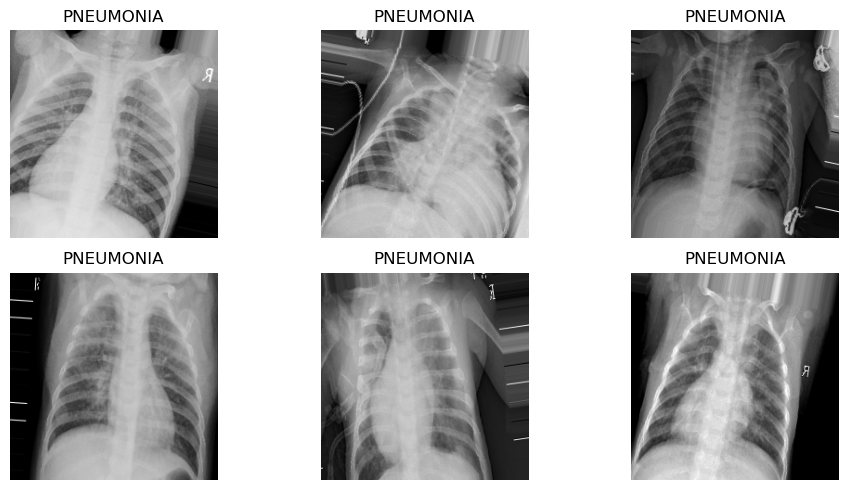

In [8]:
plt.figure(figsize=(10,5))

images, labels = next(train_generator)

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

plt.tight_layout()
plt.show()



In [9]:
base_model = VGG19(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [10]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(2, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,288,066 (77.39 MB)

 Trainable params: 263,682 (1.01 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [11]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [12]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ModelCheckpoint("best_vgg19_pneumonia.h5", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=2)
]


In [13]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks
)


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6969 - loss: 0.6228

163/163 ━━━━━━━━━━━━━━━━━━━━ 720s 4s/step - accuracy: 0.7458 - loss: 0.5342 - val_accuracy: 0.5625 - val_loss: 0.6226 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8187 - loss: 0.3968

163/163 ━━━━━━━━━━━━━━━━━━━━ 706s 4s/step - accuracy: 0.8322 - loss: 0.3717 - val_accuracy: 0.7500 - val_loss: 0.5500 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8515 - loss: 0.3196

163/163 ━━━━━━━━━━━━━━━━━━━━ 692s 4s/step - accuracy: 0.8572 - loss: 0.3164 - val_accuracy: 0.8125 - val_loss: 0.4921 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 688s 4s/step - accuracy: 0.8758 - loss: 0.2907 - val_accuracy: 0.7500 - val_loss: 0.5580 - learning_rate: 1.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 688s 4s/step - accuracy: 0.8771 - loss: 0.2785 - val_accuracy: 0.7500 - val_loss: 0.5761 - learning_rate: 1.0000e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 689s 4s/step - accuracy: 0.8848 - loss: 0.2669 - val_accuracy: 0.7500 - val_loss: 0.5411 - learning_rate: 3.0000e-05


In [14]:
for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

fine_tune_history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=callbacks
)


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9015 - loss: 0.2352

163/163 ━━━━━━━━━━━━━━━━━━━━ 864s 5s/step - accuracy: 0.9162 - loss: 0.2016 - val_accuracy: 0.8125 - val_loss: 0.3414 - learning_rate: 1.0000e-05
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 801s 5s/step - accuracy: 0.9438 - loss: 0.1451 - val_accuracy: 0.7500 - val_loss: 0.4020 - learning_rate: 1.0000e-05
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9566 - loss: 0.1155

163/163 ━━━━━━━━━━━━━━━━━━━━ 802s 5s/step - accuracy: 0.9597 - loss: 0.1078 - val_accuracy: 0.8125 - val_loss: 0.2932 - learning_rate: 1.0000e-05
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9560 - loss: 0.1107

163/163 ━━━━━━━━━━━━━━━━━━━━ 800s 5s/step - accuracy: 0.9618 - loss: 0.1016 - val_accuracy: 0.8125 - val_loss: 0.2018 - learning_rate: 1.0000e-05
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 798s 5s/step - accuracy: 0.9688 - loss: 0.0844 - val_accuracy: 0.8125 - val_loss: 0.3298 - learning_rate: 1.0000e-05


In [16]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.9022 - loss: 0.2824
Test Accuracy: 0.9022


20/20 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step


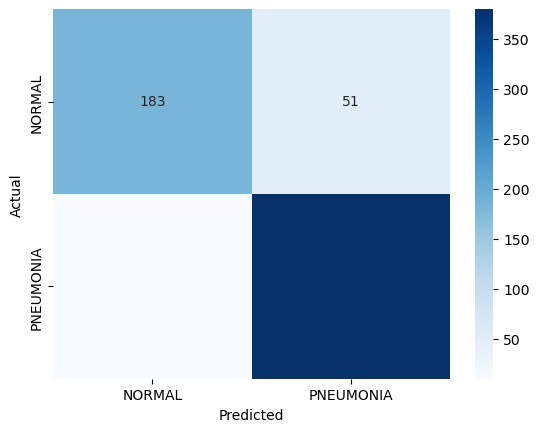

              precision    recall  f1-score   support

      NORMAL       0.95      0.78      0.86       234
   PNEUMONIA       0.88      0.97      0.93       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.91      0.90      0.90       624



In [17]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names.values(),
            yticklabels=class_names.values())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names.values()))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
🫁 PNEUMONIA detected (99.88%)


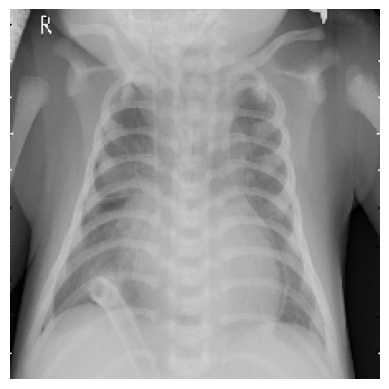

In [22]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

img_path = r"C:\Users\NC\Documents\person19_bacteria_60.jpeg"

img = image.load_img(img_path, target_size=(224,224))
plt.imshow(img)
plt.axis("off")

img = image.img_to_array(img)/255.0
img = np.expand_dims(img, axis=0)

prediction = model.predict(img)[0]

normal_prob = prediction[0]
pneumonia_prob = prediction[1]

if pneumonia_prob > normal_prob:
    print(f"🫁 PNEUMONIA detected ({pneumonia_prob*100:.2f}%)")
else:
    print(f"✅ NORMAL chest X-ray ({normal_prob*100:.2f}%)")




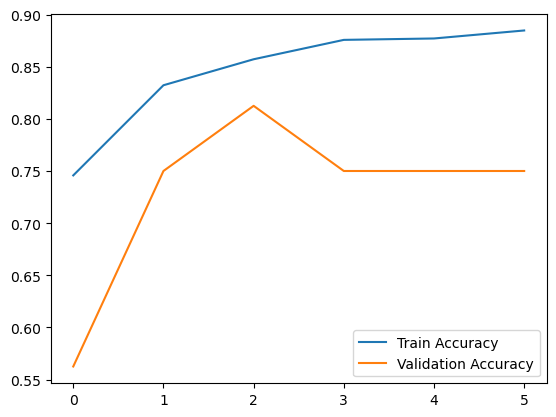

In [23]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


In [24]:
prediction = model.predict(img)

print("NORMAL:", prediction[0][0])
print("PNEUMONIA:", prediction[0][1])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
NORMAL: 0.001217641
PNEUMONIA: 0.99878234


In [25]:
model.save("pneumonia_detector.keras")
